In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [274]:
martabase = pd.read_csv("martabase_final.csv")

In [275]:
martabase.head()

,ID,Station,Latitude,Longitude,Color
0,1,Airport,33.640758,-84.446341,NaN
1,2,Arts Center,33.789705,-84.387789,NaN
2,3,Ashby,33.756346,-84.417556,NaN
3,4,Avondale,33.775277,-84.281903,NaN
4,5,Bankhead,33.771890,-84.428840,NaN


In [276]:
martabase.shape

(160, 5)

In [277]:
import folium

mapmarta=folium.Map(location=[33.934150, -84.246706])

for ind in range(len(martabase["Station"])):
    name = martabase.iloc[ind,1]
    lat = martabase.iloc[ind,2]
    longi = martabase.iloc[ind,3]
    folium.Marker([lat,longi],tooltip=name, icon=folium.Icon(color='black',icon_color='red')).add_to(mapmarta)
mapmarta

In [278]:
from collections import defaultdict

class Graph:
    def __init__(self, vertices):
        self.V = vertices
        self.graph = defaultdict(list)

    def addEdge(self, v1, v2):
        self.graph[v1].append(v2)
        self.graph[v2].append(v1)

    def DepthFirst(self, v, visited_list):
        visited_list[v] = True
        for i in self.graph[v]:
            if visited_list[i] == False:
                self.DepthFirst(i, visited_list)
    
    def isConnected(self):
        visited_list = False*(self.V)
        for i in range(self.V):
            if(len(self.graph[i]) != 0):
                break
        if i == self.V-1:
            return True
       
        self.DepthFirst(i, visited_list)
 
        # Check if all non-zero degree vertices are visited
        for i in range(self.V):
            if visited_list[i] == False and len(self.graph[i]) > 0:
                return False
 
        return True
    
    def isEulerian(self):
        # Check if all non-zero degree vertices are connected
        if self.isConnected() == False:
            return 0
        else:
            # Count vertices with odd degree
            odd = 0
            for i in range(self.V):
                if len(self.graph[i]) % 2 != 0:
                    odd += 1
            #number of odds:
                # 0 -> euler cycle
                # 2 -> euler path 
                # >2 -> not eulerian 
            if odd == 0:
                return 2 #euler cycle
            elif odd == 2:
                return 1 #euler path
            elif odd > 2:
                return 0 #no euler
    
    def test(self):
        res = self.isEulerian()
        if res == 0:
            print("Graph is not Eulerian")
        elif res == 1:
            print("Graph has a Euler path")
        else:
            print("Graph has a Euler cycle")

In [279]:
g = Graph(160)
g.addEdge(1,2)

In [280]:
names = martabase.iloc[:,1]
latitudes = martabase.iloc[:,2]
longitudes = martabase.iloc[:,3]
longitudes.head()

0   -84.446341
1   -84.387789
2   -84.417556
3   -84.281903
4   -84.428840
Name: Longitude, dtype: float64

In [281]:
npnames = names.to_numpy()
nplats = latitudes.to_numpy()
nplongs = longitudes.to_numpy()

In [282]:
from sklearn.preprocessing import MinMaxScaler

nplats = nplats.reshape(-1, 1)
nplongs = nplongs.reshape(-1, 1)

lats_fin = MinMaxScaler().fit_transform(nplats)
longs_fin = MinMaxScaler().fit_transform(nplongs)

In [283]:
lats_fin[0]

array([0.06162806])

In [284]:
longs_fin[0]

array([0.37190522])

In [285]:
longs = longs_fin.flatten()
lats = lats_fin.flatten()

In [286]:
vertices_finnn = pd.DataFrame({'Station': npnames, 'Latitude': lats, 'Longitude': longs})

martagraph = vertices_finnn.set_index('Station')[['Longitude', 'Latitude']].apply(tuple, axis=1).to_dict()


In [287]:
vertices_f = martabase.iloc[:,2:4]
vertices_f.head()

,Latitude,Longitude
0,33.640758,-84.446341
1,33.789705,-84.387789
2,33.756346,-84.417556
3,33.775277,-84.281903
4,33.771890,-84.428840


In [288]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [289]:
vertices_final = vertices_f.to_numpy().tolist()
vertices_final[0]

[33.640758, -84.446341]

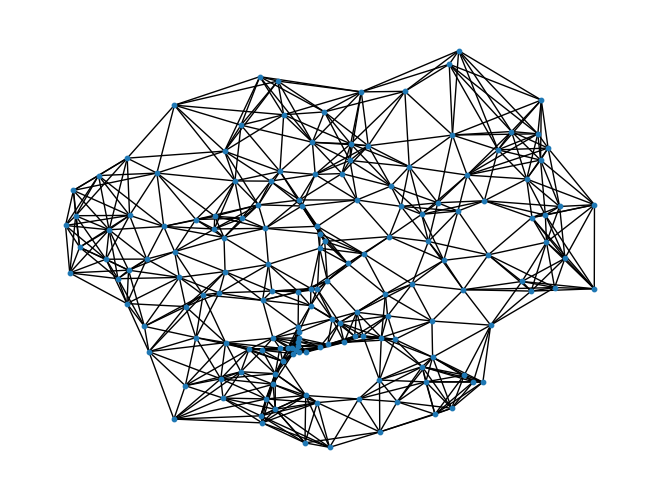

In [290]:
def distance_formula(x1, y1, x2, y2):
   dist = math.sqrt( (math.pow( (x1 - x2) ,2)) + (math.pow( (y1 - y2) ,2)) )
   return dist

def knn_edges(n, k, vertices):
    edges = []
    for key, v in vertices.items():
        # Values for x1,x2
        name = key
        y1 = v[0]
        x1 = v[1]

        # Calculate distances to other vertices
        distances = []
        for key2, u in vertices.items():
            if u[0]!=y1 and u[1]!=x1: 
                try:
                    distances.append((u, distance_formula(x1, y1, u[1], u[0])))
                except Exception as e:
                    print(f"Error calculating distance: {e}")
        
        # Sort distances
        distances.sort(key=lambda x: x[1])

        # Select k nearest neighbors and add edges
        for j in range(k):
            u, _ = distances[j]
            val = {i for i in martagraph if martagraph[i]==u}
            va = val.pop()
            edges.append((name, va, distances[j][1]))

    return edges

G = nx.Graph()

# Step 3: Add nodes and edges
for name, coordinates in martagraph.items():
    G.add_node(name, pos=coordinates)  # Add node with 'pos' attribute

edges = knn_edges(160, 8, martagraph)
#print(edges)
G.add_weighted_edges_from(edges)

# Plot the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10)
plt.show()

In [291]:
for k in range(20):
    G2 = nx.Graph()

    # Step 3: Add nodes and edges
    for name, coordinates in martagraph.items():
        G2.add_node(name, pos=coordinates)  # Add node with 'pos' attribute

    edges = knn_edges(160, k, martagraph)
    G2.add_weighted_edges_from(edges)
    try: 
        eulerian_circuit = list(nx.eulerian_circuit(G))
        # Print the Eulerian circuit
        print("Eulerian Circuit:", eulerian_circuit)

        # Visualize the graph and the Eulerian circuit
        pos = nx.spring_layout(G2)
        nx.draw(G2, pos, with_labels=True, font_weight='bold')
        nx.draw_networkx_edges(G2, pos, edgelist=eulerian_circuit, edge_color='r', width=2)
        plt.show()
    except Exception as e:
        print(f"Error not Eulerian: {e}")

Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.


In [292]:
'''def hamiltonian(graph, start, path=[]):
    path = path + [start]
    if len(path) == len(graph.nodes):
        return path
    for node in graph.neighbors(start):
        if node not in path:
            new_path = hamiltonian(graph, node, path)
            if new_path:
                return new_path
    return None

starting_node = list(G.nodes)[0]

hamiltonian_path = hamiltonian(graph=G, start=starting_node)

print("Hamiltonian Path:", hamiltonian_path)
'''
# Visualize the graph and the Hamiltonian path
'''
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=hamiltonian_path, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=[(hamiltonian_path[i], hamiltonian_path[i + 1]) for i in range(len(hamiltonian_path) - 1)], edge_color='r', width=2)
plt.show()
'''

"\npos = nx.spring_layout(G)\nnx.draw(G, pos, with_labels=True, font_weight='bold')\nnx.draw_networkx_nodes(G, pos, nodelist=hamiltonian_path, node_color='r')\nnx.draw_networkx_edges(G, pos, edgelist=[(hamiltonian_path[i], hamiltonian_path[i + 1]) for i in range(len(hamiltonian_path) - 1)], edge_color='r', width=2)\nplt.show()\n"

Eulerian Circuit: [('Airport', 'City of South Fulton Station'), ('City of South Fulton Station', 'Cascade Springs'), ('Cascade Springs', 'Deerwood Park'), ('Deerwood Park', 'Melvin Drive Park'), ('Melvin Drive Park', 'Cascade Springs'), ('Cascade Springs', 'Sandtown'), ('Sandtown', 'Melvin Drive Park'), ('Melvin Drive Park', 'Sweetwater Creek State Park'), ('Sweetwater Creek State Park', 'Lions Park'), ('Lions Park', 'Woodrow Willson Park'), ('Woodrow Willson Park', 'Hurt Road Park'), ('Hurt Road Park', 'Lions Park'), ('Lions Park', 'Heritage Park'), ('Heritage Park', 'Bishop Park'), ('Bishop Park', 'Cheatham Hill '), ('Cheatham Hill ', 'Mud Creek'), ('Mud Creek', 'Bishop Park'), ('Bishop Park', 'Wild Horse'), ('Wild Horse', 'Woodrow Willson Park'), ('Woodrow Willson Park', 'Heritage Park'), ('Heritage Park', 'Standing Peachtree Park'), ('Standing Peachtree Park', 'Palisades Unit'), ('Palisades Unit', 'Sope Creek '), ('Sope Creek ', 'Morgan Falls'), ('Morgan Falls', 'Gold Branch Trail'

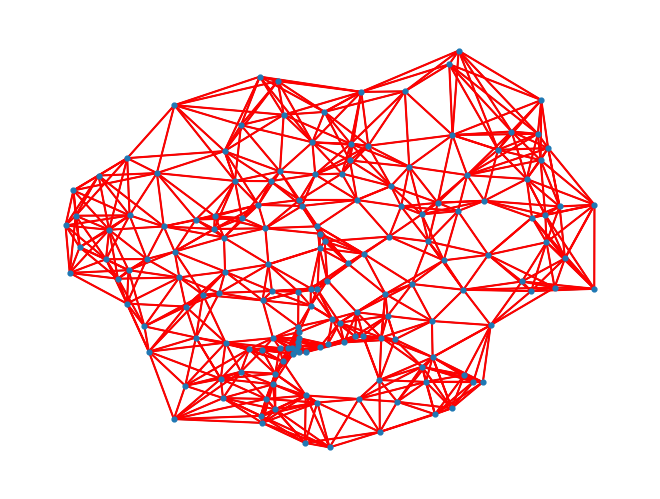

In [293]:
Ge = nx.euler.eulerize(G)

eulerian_circuit = list(nx.eulerian_circuit(Ge))

# Print the Eulerian circuit
print("Eulerian Circuit:", eulerian_circuit)

# Visualize the graph and the Eulerian circuit
pos = nx.get_node_attributes(Ge, 'pos')
nx.draw(Ge, pos, with_labels=False, node_size=12)
nx.draw_networkx_edges(Ge, pos, edgelist=eulerian_circuit, edge_color='r', width=1.5)
plt.show()

In [294]:
# example path provided by app from Avalon to Airport station using weighted Dijkstra's algo
lp = True
while lp:
    try:
        start = input("Enter your starting location: ")
        end = input("Enter your destination: ")
        print(nx.dijkstra_path(G, start, end))
        lp = False
    except Exception as e:
            print(f"Error: {e}")


Error: Node io not found in graph
['Avalon', 'North Point', 'Horseshoe Bend ', 'North Springs', 'Medical Center', 'Buckhead', 'Lindbergh Center', 'Arts Center', 'Vine City', 'West End', 'Lakewood/Fort McPherson', 'Airport']


In [295]:
for u, v, data in G.edges(data=True):
    if 'weight' not in data:
        G[u][v]['weight'] = 0.05
    #print(f"Edge ({u}, {v}): {data}")


In [296]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
import tensorflow as tf

node_features = torch.randn(160, 16)
data = torch_geometric.utils.from_networkx(G)
data.x = node_features
print(data)

# Define and train a GNN model
class GNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GNN, self).__init__()
        self.conv1 = torch_geometric.nn.GraphConv(input_size, hidden_size)
        self.conv2 = torch_geometric.nn.GraphConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(input_size=16, hidden_size=64, output_size=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model on graph data
for epoch in range(20):
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    target = torch.ones_like(output)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{20}, Loss: {loss.item()}')

# uses the learned embeddings to guide Hamiltonian path search
node_embeddings = model.conv1(data.x, data.edge_index)
print(node_embeddings)

Data(edge_index=[2, 1540], pos=[159, 2], weight=[1540], x=[160, 16])
Epoch 1/20, Loss: 3.6754250526428223
Epoch 2/20, Loss: 7.075736045837402
Epoch 3/20, Loss: 4.351600170135498
Epoch 4/20, Loss: 5.848458290100098
Epoch 5/20, Loss: 3.195577621459961
Epoch 6/20, Loss: 3.5237343311309814
Epoch 7/20, Loss: 4.00560998916626
Epoch 8/20, Loss: 2.653991937637329
Epoch 9/20, Loss: 2.611069917678833
Epoch 10/20, Loss: 3.016585350036621
Epoch 11/20, Loss: 2.355003833770752
Epoch 12/20, Loss: 2.118072032928467
Epoch 13/20, Loss: 2.5813546180725098
Epoch 14/20, Loss: 2.4784207344055176
Epoch 15/20, Loss: 1.8085826635360718
Epoch 16/20, Loss: 1.8909556865692139
Epoch 17/20, Loss: 2.1892223358154297
Epoch 18/20, Loss: 1.8698699474334717
Epoch 19/20, Loss: 1.697495460510254
Epoch 20/20, Loss: 1.9151763916015625
tensor([[ 1.2764, -0.0851,  4.0211,  ...,  0.6951, -0.8406, -1.1633],
        [ 0.5514,  0.5048,  1.0761,  ..., -0.4511, -0.9251,  1.0614],
        [ 2.7418, -4.4167,  2.8022,  ..., -1.3299, -

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b3686541-b591-45d5-90b4-564457237abf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>